In [ ]:
import tensorflow as tf
print("Version of tensorflow is : ",tf.__version__)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense , Dropout , Lambda , Input , Flatten
from tensorflow.nn import relu , sigmoid
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as k

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [25]:
def create_pairs(images , digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    for d in range (10):
        for i in range(n):
            z1 , z2 = digit_indices[d][i] , digit_indices[d][i+1]
            pairs += [[images[z1] , images[z2]]]
            rand = random.randrange(1,10)
            dn = (d + rand) % 10
            z1 , z2 = digit_indices[d][i] , digit_indices[dn][i+1]
            pairs += [[images[z1] , images[z2]]]
            labels += [1,0]
    return np.array(pairs) , np.array(labels)

def create_pair_on_set(images , label):
    digit_indices = [np.where(label == i)[0] for i in range(10)]
    pairs , y = create_pairs(images , digit_indices)
    y = y.astype('float32')
    return pairs , y 

In [26]:
(train_image , train_label) , (test_image , test_label) = fashion_mnist.load_data()
train_image = train_image.astype('float32')
test_image  = test_image.astype('float32')
train_image = train_image / 255.0
test_image  = test_image  / 255.0

train_pairs , train_labels = create_pair_on_set(train_image , train_label)
test_pairs  , test_labels  = create_pair_on_set(test_image  , test_label )

In [35]:
def show_pair_images(img_ind , images = train_pairs , label=train_labels):
    _ , ax = plt.subplots(1,2,figsize=(10,4))
    ax[0].imshow(images[img_ind][0])
    ax[1].imshow(images[img_ind][1])
    print("Is they same : " , bool(train_labels[img_ind]))

Is they same :  True


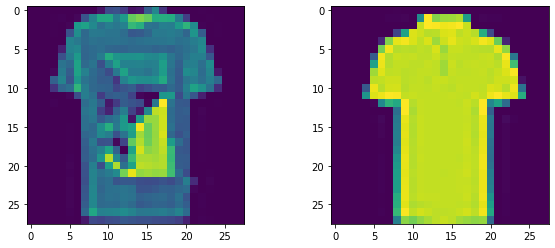

In [36]:
show_pair_images(100)

Is they same :  False


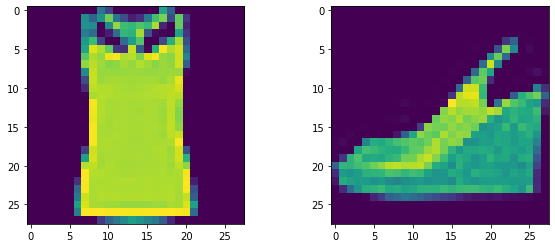

In [37]:
show_pair_images(1001)

In [41]:
def euclidean_distance(vects):
    x , y = vects
    sum_square = k.sum(k.square(x - y) , axis=1 , keepdims=True)
    return k.sqrt(k.maximum(sum_square , k.epsilon()))

def euclidean_dist_output_shape(shapes):
    shape1 , shape2 = shapes
    return (shape1[0] , 1)

In [49]:
def create_base_model():
    input = Input(shape = (28 , 28))
    flatten = Flatten()(input)
    layer1 = Dense(128 , activation=relu , name="layer1")(flatten)
    dropout1 = Dropout(0.1 , name="dropout1")(layer1)
    layer2 = Dense(128 , activation=relu , name="layer2")(dropout1)
    dropout2 = Dropout(0.1 , name="dropout2")(layer2)
    layer3 = Dense(128 , activation=relu , name="layer3")(dropout2)

    return Model(inputs=input , outputs=layer3)

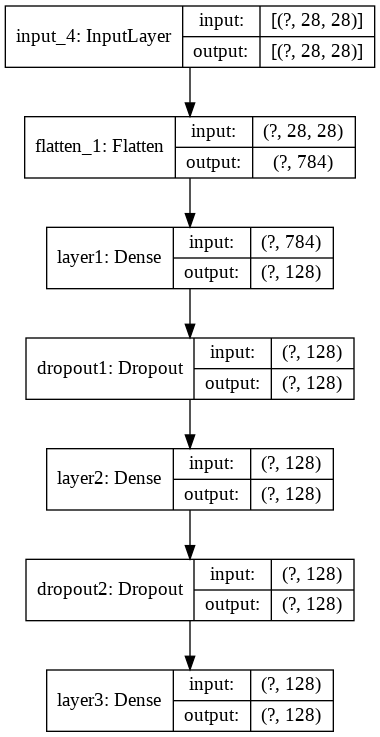

In [50]:
base_network = create_base_model()
plot_model(base_network , to_file="multi_input.png",show_shapes=True , show_layer_names=True)

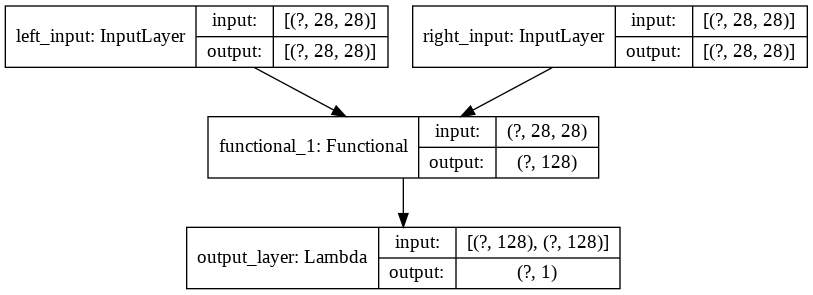

In [53]:
input_left = Input(shape=(28 , 28) , name="left_input")
vector_output1 = base_network(input_left)

input_right = Input(shape=(28 , 28) , name="right_input")
vector_output2 = base_network(input_right)

output = Lambda(euclidean_distance , name = "output_layer" , output_shape = euclidean_dist_output_shape)([vector_output1 , vector_output2])
model = Model(inputs = [input_left , input_right] , outputs = output)
plot_model(model , to_file="multi_input_main_model.png",show_shapes=True , show_layer_names=True)

In [54]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 128)          133504      left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
output_layer (Lambda)           (None, 1)            0           functional_1[1][0]    

In [55]:
def constructive_loss_with_margin(margin):
    def constructive_loss(y_true , y_pred):
        square_pred = k.square(y_pred)
        margin_square = k.square(k.maximum(margin - y_pred , 0))
        return k.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return constructive_loss

In [56]:
model.compile(optimizer="rmsprop" , loss=constructive_loss_with_margin(1))

In [57]:
history = model.fit([train_pairs[: , 0] , train_pairs[: , 1]] , train_labels , 
    epochs=20,
    validation_data=([test_pairs[:,0] , test_pairs[:,1]] , test_labels)
)

Epoch 1/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.1054 - val_loss: 0.0930
Epoch 2/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0803 - val_loss: 0.0785
Epoch 3/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0745 - val_loss: 0.0758
Epoch 4/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0717 - val_loss: 0.0696
Epoch 5/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0694 - val_loss: 0.0700
Epoch 6/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0686 - val_loss: 0.0721
Epoch 7/20
3750/3750 [==============================] - 11s 3ms/step - loss: 0.0676 - val_loss: 0.0705
Epoch 8/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0668 - val_loss: 0.0716
Epoch 9/20
3750/3750 [==============================] - 12s 3ms/step - loss: 0.0661 - val_loss: 0.0715
Epoch 10/20
3750/3750 [==============================] - 11s 3ms/step - l

Text(0.5, 1.0, 'Crossentropy')

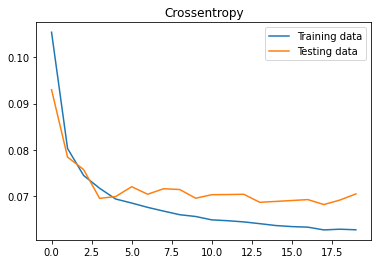

In [59]:
plt.plot(history.history['loss'] , label="Training data")
plt.plot(history.history['val_loss'] , label = "Testing data")
plt.legend()
plt.title("Crossentropy")

In [64]:
model.evaluate([test_pairs[:,0] , test_pairs[:,1]] , test_labels)

625/625 [==============================] - 1s 1ms/step - loss: 0.0705


0.07053282856941223

In [65]:
y_pred = model.predict([test_pairs[:,0] , test_pairs[:,1]])

In [107]:
def accurecy(y_true , y_pred):
    p = y_pred.ravel() < 0.5
    return np.mean(p == y_true)

In [108]:
print("Accurecy is : ",accurecy(test_labels , y_pred))

Accurecy is :  0.9038538538538539


In [109]:
pred = model.predict([test_pairs[:8 , 0] , test_pairs[:8 , 1]])
pred_ = np.where(pred < 0.5 , 1 ,0).ravel()
print("Prediction : ",pred_.astype('float32'))
print("True       : ",test_labels[:8])

Prediction :  [1. 0. 1. 0. 1. 0. 1. 0.]
True       :  [1. 0. 1. 0. 1. 0. 1. 0.]


In [110]:
pred

array([[3.1622776e-04],
       [1.3966533e+00],
       [3.1622776e-04],
       [9.9970877e-01],
       [3.1622776e-04],
       [9.4241512e-01],
       [3.1622776e-04],
       [7.7896178e-01]], dtype=float32)

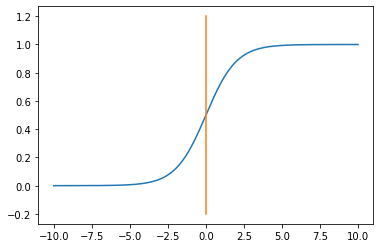

In [111]:
#sigmoid
e = 1 / (1 + np.exp(-1 * np.arange(-10,10,0.01)))
plt.plot(np.arange(-10,10,0.01) , e)
plt.plot([0,0,0],[-0.2,0.5,1.2])